<a href="https://colab.research.google.com/github/Ignas12345/Magistro_projektas/blob/main/knygutes/ketvirtas_bandymas_klasifikuoti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [2]:
# uzkraunam neapdorotus duomenis
url = 'https://raw.githubusercontent.com/Ignas12345/Magistro_projektas/refs/heads/main/counts_combined.csv'
df = pd.read_csv(url)
full_gene_names = df["miRNA_ID"].to_numpy()
df_trimmed = df.drop(df.columns[0], axis=1)
full_data = (df_trimmed.to_numpy(dtype=np.int32))
print(np.shape(full_data))

(1881, 139)


In [3]:

# Papildomas filtravimas, jei reikia
#Calculate the percentage of values less than 100 for each row
min_counts = 1000
max_below_min_counts = 0.98
percent_less_than_100 = np.sum(full_data < min_counts, axis=1) / full_data.shape[1]

# Keep only rows where values less than min_counts occur max_below_min_counts or less of the time
filtered_data = full_data[percent_less_than_100 <= max_below_min_counts]
filtered_gene_names = full_gene_names[percent_less_than_100 <= max_below_min_counts]

# Display the filtered array
print(np.shape(filtered_data))

(300, 139)


In [4]:
X = filtered_data.T
gene_ids = filtered_gene_names
print(np.shape(X))

(139, 300)


In [ ]:
print(X[:5, 105])
print((np.delete(X, 2, axis = 0))[:4, 105])

[87325 48793  9623 40540 78825]
[87325 48793 40540 78825]


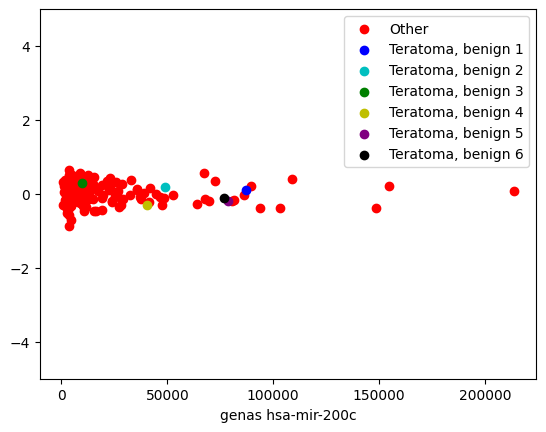

In [5]:
try:
  #i=np.where(gene_ids == 'hsa-mir-520f')[0][0]
  i = 105


  plt.scatter(X[6:139, i], np.random.normal(scale=0.3, size = len(X[6:139, 0])), c = 'r', label = 'Other')
  plt.scatter(X[0, i], 0.1, c = 'b', label = 'Teratoma, benign 1')
  plt.scatter(X[1, i], 0.2, c = 'c', label = 'Teratoma, benign 2')
  plt.scatter(X[2, i], 0.3, c = 'g', label = 'Teratoma, benign 3')
  plt.scatter(X[3, i], -0.3, c = 'y', label = 'Teratoma, benign 4')
  plt.scatter(X[4, i], -0.2, c = 'purple', label = 'Teratoma, benign 5')
  plt.scatter(X[5, i], -0.1, c = 'k', label = 'Teratoma, benign 6')
  plt.xlabel('genas ' + str(gene_ids[i]))
  plt.ylim(-5, 5)
  plt.legend()
  plt.show()
except:
    print('Sitas genas isfiltruotas - reiktu pakeisti X matrica')

In [ ]:
import numpy as np

# Create a 2D NumPy array
arr = np.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])

# Row index to filter out
row_to_filter = 1

# Remove the specified row
filtered_arr = np.delete(arr, row_to_filter, axis=0)

print("Original array:\n", arr)
print("Array after removing row:\n", filtered_arr)


Original array:
 [[1 2 3]
 [4 5 6]
 [7 8 9]]
Array after removing row:
 [[1 2 3]
 [7 8 9]]


In [83]:
# Create labels: first 6 samples -> label 0, rest -> label 1
num_samples = X.shape[0]
labels = torch.zeros(num_samples, dtype=torch.float32)
labels[6:] = 1  # Set the rest of the samples to label 1

# Convert X to a PyTorch tensor
features = torch.tensor(X, dtype=torch.float32)
mean = features.mean(dim=0)
std = features.std(dim=0)

#jeigu norim, galim istrinti isskirtini elementa
num_samples = X.shape[0] - 1
features = torch.tensor(np.delete(X, 2, axis = 0), dtype=torch.float32)
labels = torch.zeros(num_samples, dtype=torch.float32)
labels[5:] = 1
# cia baigiasi isskirtinio meginio istrynimas (uzkomentuoti sias elutes jeigu to nenorim)

#netikri papildomi treniravimo duomenys
benign_features = features[np.where(labels == 0)]  # First 6 samples are benign
benign_labels = labels[np.where(labels == 0)]


# Duplicate benign samples with slight noise
for i in range(10):
  augmented_features = benign_features + 0.01 * torch.randn_like(benign_features)
  features = torch.cat([features, augmented_features])
  labels = torch.cat([labels, benign_labels])

features = (features - mean) / (std + 1e-8)

# Combine features and labels into a dataset
dataset = TensorDataset(features, labels)

In [84]:
test_labels = torch.zeros(139, dtype=torch.float32)
test_labels[6:] = 1
test_features = torch.tensor(X, dtype=torch.float32)
test_features = (test_features - mean) / (std + 1e-8)

In [93]:
from imblearn.over_sampling import RandomOverSampler

#dar padauginam benign meginiu
# Convert data to numpy for resampling
features_np = features.numpy()
labels_np = labels.numpy()

# Oversample
ros = RandomOverSampler()
features_resampled, labels_resampled = ros.fit_resample(features_np, labels_np)

# Convert back to tensors
features = torch.tensor(features_resampled, dtype=torch.float32)
labels = torch.tensor(labels_resampled, dtype=torch.float32)

dataset = TensorDataset(features, labels)

In [99]:
print(np.shape(labels))

torch.Size([266])


In [ ]:
print(labels[labels == 0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [12]:
# Create a DataLoader for batching
batch_size = 2  # You can adjust this as needed
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example: Print the shape of a batch
for batch_features, batch_labels in data_loader:
    print(f"Batch features shape: {batch_features.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break

Batch features shape: torch.Size([2, 300])
Batch labels shape: torch.Size([2])


In [ ]:
print(features[0])

In [ ]:
for batch_features, batch_labels in data_loader:
    print(f"Batch features shape: {batch_features}")
    print(f"Batch labels shape: {batch_labels}")
    break

Batch features shape: tensor([[-0.4202, -0.4190, -0.4189, -0.5222, -0.4267, -0.4379, -0.5122, -0.3789,
         -0.3905, -0.2518, -0.4331, -0.5286, -0.0767, -0.0914, -0.6333, -0.6347,
          1.5937,  1.5757, -0.6209, -0.8597, -0.6032, -0.6093, -0.3402, -0.4592,
         -0.3929, -0.7102, -0.5144, -0.5066, -0.5726, -0.2692,  0.1066,  0.2820,
         -0.0914, -0.1206, -0.3672,  0.0884, -0.5307, -0.0728, -0.5520, -0.9523,
         -0.4180, -0.5381, -0.2854, -0.7428, -0.3375, -0.3485, -0.3906, -0.4429,
          0.4400, -0.2638, -0.6155, -0.2417,  0.1125, -0.5115,  1.0740, -0.2824,
         -0.1617,  0.0269, -0.0662, -0.4925, -0.1999, -0.0687, -0.1604, -0.6651,
          0.5691, -0.4192, -0.2966, -0.6920, -0.4501, -0.4978, -0.5041, -0.4984,
         -0.3729, -0.4540, -0.0171,  0.3037, -0.3918, -0.3279, -0.5138, -0.3938,
         -0.7908,  0.2592, -0.1739, -0.3517, -0.8469,  0.6807, -0.2942, -0.2999,
         -0.1894, -0.5065, -0.4219,  0.1239, -0.5509, -0.5626, -0.5792, -0.7760,
      

In [94]:
class SparseNN(nn.Module):
    def __init__(self, input_dim, temperature = 1):
        super(SparseNN, self).__init__()
        self.input_dim = input_dim
        self.temperature = temperature
        self.first_layer_biases = nn.Parameter(torch.randn(input_dim))
        self.output_weights = nn.Parameter(torch.randn(input_dim))  # Raw weights

    def forward(self, x):

        first_layer_output = torch.tanh((x + self.first_layer_biases))
        weighted_output = first_layer_output * self.output_weights
        pooled_output = weighted_output.sum(dim=1)

        output = torch.sigmoid(pooled_output / self.temperature)

        return output

def l1_regularization(weight, lambda_l1=0.001):
    return lambda_l1 * weight.abs().sum()



In [95]:
#initialize the model
input_dim = features.shape[1]
model = SparseNN(input_dim, temperature = 1)
lambda_l1 = 0.05

# Define a loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # L1 sparsity via weight_decay

In [97]:
# Training Loop
num_epochs = 40  # Adjust based on dataset size and convergence

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_features, batch_labels in data_loader:
        # Forward pass
        outputs = model(batch_features)  # Ensure shape compatibility for BCELoss
        # Compute binary cross-entropy loss
        loss = criterion(outputs, batch_labels)

        # Add L1 regularization for sparsity
        loss += l1_regularization(model.output_weights, lambda_l1)

        #make probabilities less extreme
        penalty = (outputs * torch.log(outputs + 1e-8) + (1 - outputs) * torch.log(1 - outputs + 1e-8)).mean()
        loss += 0.1 * penalty

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Logging epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(data_loader):.4f}")

# Evaluation (after training)
model.eval()
with torch.no_grad():
    predictions = model(features)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary predictions

    # Compute accuracy
    accuracy = accuracy_score(labels.numpy(), predictions.numpy())
    print(f"Training Accuracy: {accuracy:.4f}")

    # Forward pass on the entire dataset
    predictions = model(test_features)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary predictions

    # Compute accuracy
    accuracy = accuracy_score(test_labels.numpy(), predictions.numpy())
    print(f"Accuracy over original data set: {accuracy:.4f}")

Epoch [1/40], Loss: 0.9474
Epoch [2/40], Loss: 0.8721
Epoch [3/40], Loss: 0.8044
Epoch [4/40], Loss: 0.7471
Epoch [5/40], Loss: 0.7003
Epoch [6/40], Loss: 0.6518
Epoch [7/40], Loss: 0.6198
Epoch [8/40], Loss: 0.5884
Epoch [9/40], Loss: 0.5635
Epoch [10/40], Loss: 0.5411
Epoch [11/40], Loss: 0.5205
Epoch [12/40], Loss: 0.5014
Epoch [13/40], Loss: 0.4810
Epoch [14/40], Loss: 0.4665
Epoch [15/40], Loss: 0.4530
Epoch [16/40], Loss: 0.4396
Epoch [17/40], Loss: 0.4303
Epoch [18/40], Loss: 0.4198
Epoch [19/40], Loss: 0.4122
Epoch [20/40], Loss: 0.4046
Epoch [21/40], Loss: 0.3968
Epoch [22/40], Loss: 0.3935
Epoch [23/40], Loss: 0.3880
Epoch [24/40], Loss: 0.3859
Epoch [25/40], Loss: 0.3815
Epoch [26/40], Loss: 0.3777
Epoch [27/40], Loss: 0.3744
Epoch [28/40], Loss: 0.3721
Epoch [29/40], Loss: 0.3667
Epoch [30/40], Loss: 0.3634
Epoch [31/40], Loss: 0.3625
Epoch [32/40], Loss: 0.3547
Epoch [33/40], Loss: 0.3507
Epoch [34/40], Loss: 0.3477
Epoch [35/40], Loss: 0.3447
Epoch [36/40], Loss: 0.3452
E

In [98]:

probs = 100 * model(test_features).detach().numpy()
formatted_probs = np.array([f"{p:.2f}%" for p in probs])
print(formatted_probs)


['6.98%' '9.92%' '90.40%' '12.88%' '11.55%' '8.60%' '86.85%' '84.53%'
 '79.34%' '88.07%' '66.98%' '87.29%' '79.36%' '88.49%' '75.67%' '88.46%'
 '89.40%' '88.40%' '88.69%' '45.60%' '91.54%' '17.49%' '35.07%' '90.21%'
 '87.36%' '71.73%' '89.21%' '51.44%' '90.51%' '14.52%' '91.79%' '90.32%'
 '89.73%' '88.26%' '87.56%' '19.52%' '86.36%' '83.60%' '90.77%' '89.67%'
 '24.49%' '90.35%' '90.88%' '86.11%' '89.15%' '88.06%' '87.42%' '74.11%'
 '84.15%' '90.35%' '81.34%' '88.65%' '88.08%' '29.90%' '53.67%' '86.41%'
 '83.80%' '63.91%' '90.16%' '85.01%' '90.95%' '85.82%' '88.52%' '39.86%'
 '86.94%' '72.51%' '86.65%' '88.42%' '76.16%' '89.54%' '89.85%' '46.60%'
 '89.84%' '80.01%' '85.50%' '24.67%' '89.83%' '88.68%' '83.96%' '45.82%'
 '82.73%' '89.57%' '84.79%' '84.61%' '88.30%' '85.92%' '75.64%' '91.66%'
 '90.51%' '86.77%' '87.13%' '47.85%' '45.89%' '88.72%' '85.59%' '85.12%'
 '85.75%' '87.90%' '83.87%' '82.36%' '91.16%' '85.81%' '88.80%' '87.64%'
 '68.86%' '86.29%' '91.78%' '88.93%' '88.42%' '53.20%'

In [ ]:
#jeigu procentai sutampa su tikrove, issaugom svorius (ir jeigu jie naudingi...)

torch.save(model.first_layer_weights.data, "first_layer_weights.pt")

# Save the first layer's biases (if present)
torch.save(model.first_layer_biases.data, "first_layer_biases.pt")

# Save the second layer (sparse) weights
torch.save(model.output_weights_raw.data, "output_weights_raw.pt")

In [74]:
# Svoriu analize is idejos turetu parodyti, kurie genai yra svarbiausi priimant sprendima

sorted_indices = torch.argsort(np.abs(model.output_weights.data), descending=True)
values_weights = model.output_weights.data[sorted_indices]
values_biases = model.first_layer_biases.data[sorted_indices]
genes = gene_ids[sorted_indices]

print(sorted_indices[:30])
print('sorted weights ' + str(values_weights[:30]))
print('sorted biases ' + str(values_biases[:30]))
print(gene_ids[291])

tensor([ 67,  87, 191,  91, 185, 117, 255, 126, 274, 279,  85, 290, 150,  93,
        188, 197,   2, 210, 135, 227, 111, 271, 134,  30,  97, 156,  76,  63,
        297, 264])
sorted weights tensor([-0.9103, -0.8004,  0.7619, -0.6423, -0.5180, -0.4697,  0.4430, -0.4390,
         0.3995, -0.2939, -0.2910,  0.2797, -0.2783, -0.2750, -0.2216, -0.1822,
        -0.1798,  0.1780, -0.1768,  0.1052, -0.0349, -0.0168, -0.0125, -0.0124,
        -0.0088, -0.0076, -0.0074, -0.0072, -0.0068, -0.0067])
sorted biases tensor([-0.4269, -1.9018, -1.4906, -3.1825, -0.0976,  2.1535,  3.0762, -0.6520,
        -0.3079,  0.1847, -0.3911,  1.1758,  0.0234, -0.1423, -0.0895, -0.0610,
         0.0601,  1.8357, -0.2908, -1.2400,  1.4314, -0.4194, -0.4134, -0.2581,
        -0.5174,  0.0151, -0.2513, -0.2661, -0.1082, -0.5629])
hsa-mir-9-3


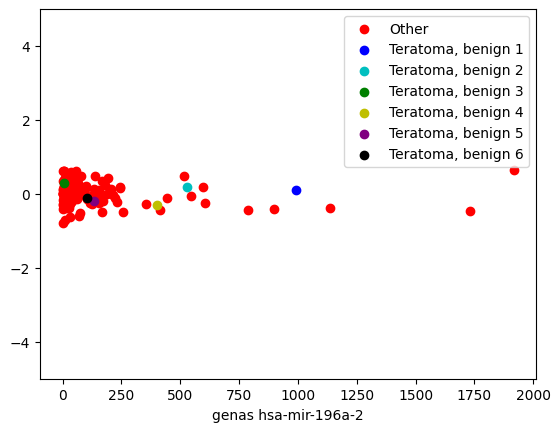

In [69]:
try:
  #i=np.where(gene_ids == 'hsa-mir-520f')[0][0]
  i = 94


  plt.scatter(X[6:139, i], np.random.normal(scale=0.3, size = len(X[6:139, 0])), c = 'r', label = 'Other')
  plt.scatter(X[0, i], 0.1, c = 'b', label = 'Teratoma, benign 1')
  plt.scatter(X[1, i], 0.2, c = 'c', label = 'Teratoma, benign 2')
  plt.scatter(X[2, i], 0.3, c = 'g', label = 'Teratoma, benign 3')
  plt.scatter(X[3, i], -0.3, c = 'y', label = 'Teratoma, benign 4')
  plt.scatter(X[4, i], -0.2, c = 'purple', label = 'Teratoma, benign 5')
  plt.scatter(X[5, i], -0.1, c = 'k', label = 'Teratoma, benign 6')
  plt.xlabel('genas ' + str(gene_ids[i]))
  plt.ylim(-5, 5)
  plt.legend()
  plt.show()
except:
    print('Sitas genas isfiltruotas - reiktu pakeisti X matrica')

In [ ]:
model = SparseNN(input_dim, temperature = 5)

loaded_first_layer_weights = torch.load("first_layer_weights.pt")
loaded_first_layer_biases = torch.load("first_layer_biases.pt")
loaded_otput_weights_raw = torch.load("output_weights_raw.pt")

# Assign the loaded values to the model
model.first_layer_weights.data = loaded_first_layer_weights
model.first_layer_biases.data = loaded_first_layer_biases
model.output_weights_raw.data = loaded_otput_weights_raw

probs = 100 * model(features).detach().numpy()
formatted_probs = np.array([f"{p:.2f}%" for p in probs])
print(formatted_probs)

['0.28%' '2.63%' '98.76%' '13.91%' '6.85%' '2.21%' '100.00%' '99.84%'
 '99.97%' '99.61%' '99.25%' '99.98%' '100.00%' '100.00%' '99.84%' '96.65%'
 '99.59%' '99.98%' '100.00%' '99.96%' '99.95%' '100.00%' '99.56%' '99.91%'
 '99.99%' '100.00%' '99.87%' '98.75%' '99.90%' '91.62%' '99.97%' '99.85%'
 '99.57%' '100.00%' '93.07%' '99.83%' '99.97%' '100.00%' '100.00%'
 '100.00%' '78.69%' '85.09%' '99.97%' '99.86%' '99.94%' '99.91%' '98.92%'
 '96.46%' '100.00%' '99.58%' '100.00%' '98.58%' '99.46%' '99.59%'
 '100.00%' '98.60%' '97.74%' '100.00%' '100.00%' '99.84%' '100.00%'
 '100.00%' '93.83%' '84.41%' '99.85%' '99.96%' '100.00%' '99.79%' '99.79%'
 '99.93%' '99.92%' '92.36%' '100.00%' '99.76%' '99.98%' '99.78%' '99.87%'
 '99.77%' '100.00%' '97.00%' '91.85%' '79.52%' '99.78%' '84.40%' '99.07%'
 '100.00%' '99.98%' '99.56%' '99.98%' '100.00%' '100.00%' '95.92%'
 '99.38%' '92.33%' '99.79%' '100.00%' '99.97%' '99.04%' '100.00%'
 '100.00%' '99.99%' '99.54%' '99.99%' '100.00%' '99.99%' '98.96%' '99.99%'


<ipython-input-84-6c24784f2594>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_first_layer_weights = torch.load("first_layer_weights.pt")
<ipython-input-84-6c24784f